# 라이브러리 로드

In [1]:
import pandas as pd

import os

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

# 데이터 로드

In [2]:
boy_group = ['SEVENTEEN', 'BTS', 'Stray Kids', 'NCT DREAM', 'TOMORROW X TOGETHER']
girl_group = ['IVE', 'aespa', 'NewJeans', 'TWICE', 'BLACKPINK']

In [3]:
# google trend
google_trend_dic = {}
for file in os.listdir(r'trend_dataset\google_trend'):

    single_google_trend_df = pd.read_csv(f'trend_dataset\google_trend\{file}', index_col=0).reset_index(drop=True)
    single_google_trend_df['date'] = pd.to_datetime(single_google_trend_df['date'])
    
    google_trend_dic[file.split('_')[0]] = single_google_trend_df

google_trend_dic.keys()

dict_keys(['aespa', 'BLACKPINK', 'BTS', 'IVE', 'NCT DREAM', 'NewJeans', 'SEVENTEEN', 'Stray Kids', 'TOMORROW X TOGETHER', 'TWICE'])

In [4]:
# naver trend
naver_trend_dic = {}
for file in os.listdir(r'trend_dataset\naver_trend'):

    naver_trend_df = pd.read_csv(rf'trend_dataset\naver_trend\{file}', index_col=0).reset_index().rename(columns={'period' : 'date', 'AESPA' : 'aespa', 'NEWJEANS' : 'NewJeans', 'TXT' : 'TOMORROW X TOGETHER'})
    naver_trend_df['date'] = pd.to_datetime(naver_trend_df['date'])

    for artist in naver_trend_df.columns[1:]:
        naver_trend_dic[artist] = naver_trend_df[['date', artist]].rename(columns={artist : 'trend'})

naver_trend_dic.keys()

dict_keys(['BTS', 'NCT DREAM', 'SEVENTEEN', 'Stray Kids', 'TOMORROW X TOGETHER', 'aespa', 'BLACKPINK', 'IVE', 'NewJeans', 'TWICE'])

In [8]:
# 아티스트 앨범 정보
# 아티스트 앨범, 공연 정보 get
artist_album_df = pd.read_csv('album_dataset/top5_group_info.csv', index_col=0)
artist_album_df = artist_album_df.drop(['main_genre', 'sub_genre'], axis=1)

album_df = artist_album_df[~artist_album_df['album_type'].isin(['Other', 'Broadcast'])].query("release_date >= '2020-01-01' and release_date <= '2024-06-30'")
album_df = album_df[['artist_name', 'debut_date', 'member_cnt', 'sub_group_cnt', 'album_name', 'album_type', 'release_date', 'track_cnt', 'avg_track_play_time']]

event_df = artist_album_df[['artist_name', 'debut_date', 'participant_type', 'event_name', 'event_type', 'event_begin_date', 'event_end_date']].drop_duplicates()
event_df = event_df.query("event_begin_date >= '2020-01-01' and event_begin_date <= '2024-06-30'")

artist_info_dic = {}
for artist_name in boy_group + girl_group:

    single_album_df = album_df[album_df['artist_name'] == artist_name].sort_values('release_date').reset_index(drop=True)
    single_album_df['release_date'] = pd.to_datetime(single_album_df['release_date'])

    single_event_df = event_df[event_df['artist_name'] == artist_name]
    single_event_df['event_begin_date'] = pd.to_datetime(single_event_df['event_begin_date'])

    single_artist_df = pd.merge(single_album_df, single_event_df.drop('debut_date', axis=1), how='inner', on='artist_name')

    artist_info_dic[artist_name] = single_artist_df

artist_info_dic.keys()

dict_keys(['SEVENTEEN', 'BTS', 'Stray Kids', 'NCT DREAM', 'TOMORROW X TOGETHER', 'IVE', 'aespa', 'NewJeans', 'TWICE', 'BLACKPINK'])

# 시각화
* google & naver 트렌드 비교

* 구글에 비해 네이버 검색어 트렌드가 훨씬 최대, 최소값 차이가 극명하게 나타남

In [9]:
def show_daily_trends(single_trend_df, single_artist_df):
    
    # Seaborn 그래프 생성
    plt.figure(figsize=(20, 6))
    
    # 라인 플롯 추가
    sns.lineplot(x='date', y='trend', data=single_trend_df, color='green', label='Trend')
    
    artist_infos = zip(single_artist_df['album_name'], single_artist_df['release_date'], single_artist_df['event_name'], single_artist_df['event_begin_date'])
    
    # 앨범 발매일과 전후 7일 구간 표시
    for specific_album, specific_date, event_name, event_begin_date in artist_infos:
        
        highlight_start = specific_date - pd.Timedelta(days=7)
        highlight_end = specific_date + pd.Timedelta(days=7)
        
        # 특정 일자 전후 7일 동안의 데이터 필터링
        highlight_data = single_trend_df[(single_trend_df['date'] >= highlight_start) & (single_trend_df['date'] <= highlight_end)]
        
        # 특정 일자 전후 7일 동안의 구간을 색칠
        plt.fill_between(highlight_data['date'], highlight_data['trend'], color='yellow', alpha=0.3)
        
        # 앨범 발매일
        release_trend_value = single_trend_df[single_trend_df['date'] == specific_date]['trend'].values[0]
        plt.scatter(specific_date, release_trend_value, color='red', s=100, zorder=5)
        plt.text(specific_date, release_trend_value, specific_album, color='red', ha='center', va='bottom')
        
        # 공연 시작일
        event_trend_value = single_trend_df[single_trend_df['date'] == event_begin_date]['trend'].values[0]
        plt.scatter(event_begin_date, event_trend_value, color='blue', s=100, zorder=5)
        plt.text(event_begin_date, event_trend_value, event_name, color='blue', ha='center', va='bottom')
    
    # 그래프 레이아웃 설정
    artist_name = single_artist_df["artist_name"].unique()[0]
    
    # plt.title(f'{artist_name} Google Trend')
    plt.xlabel('Date')
    plt.ylabel('Trend')
    plt.legend()
    
    # 그래프 출력
    plt.show()

SEVENTEEN


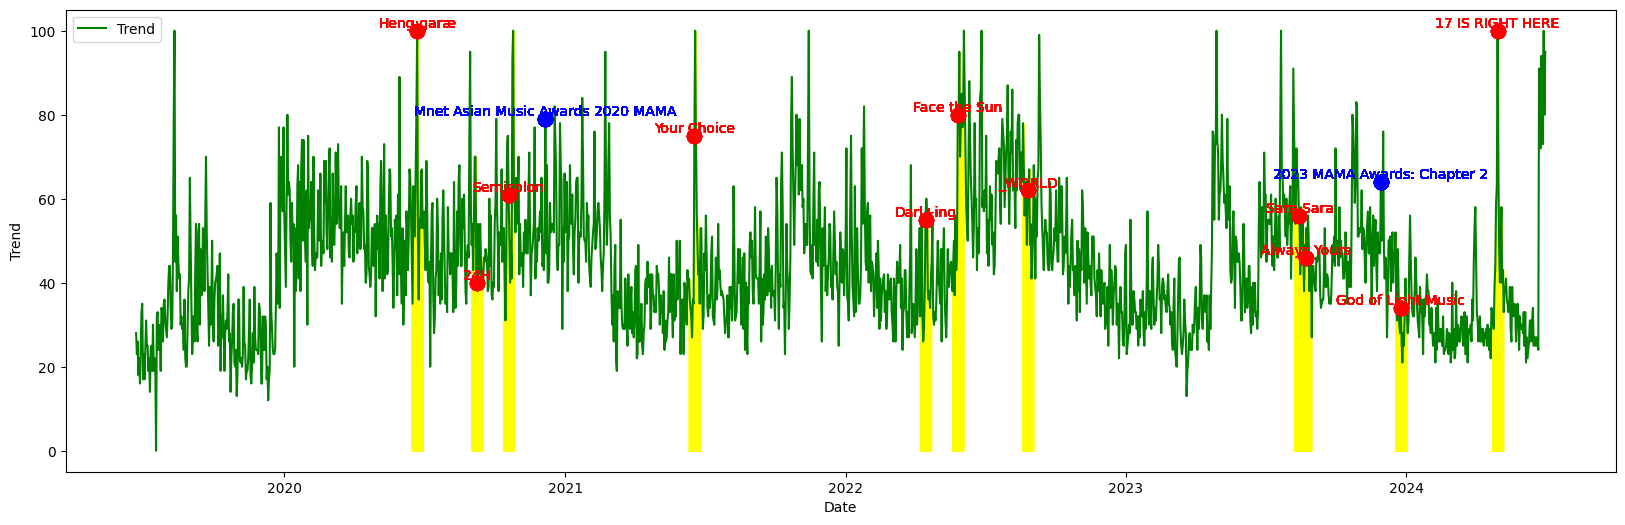

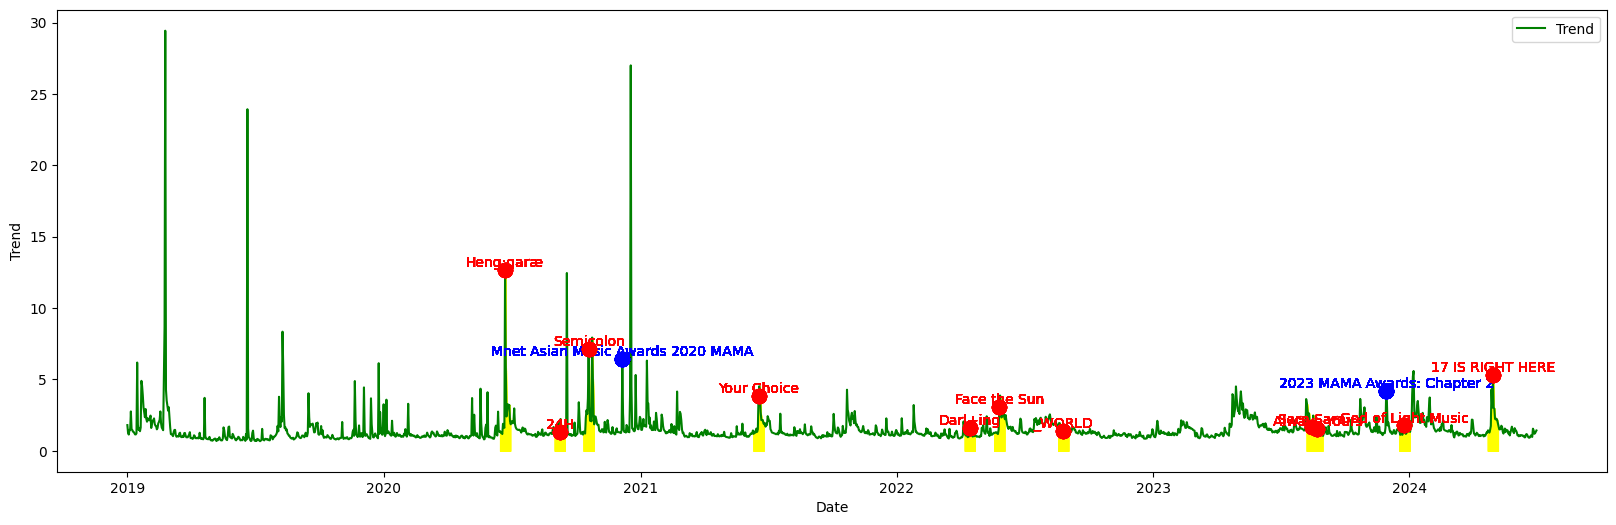

BTS


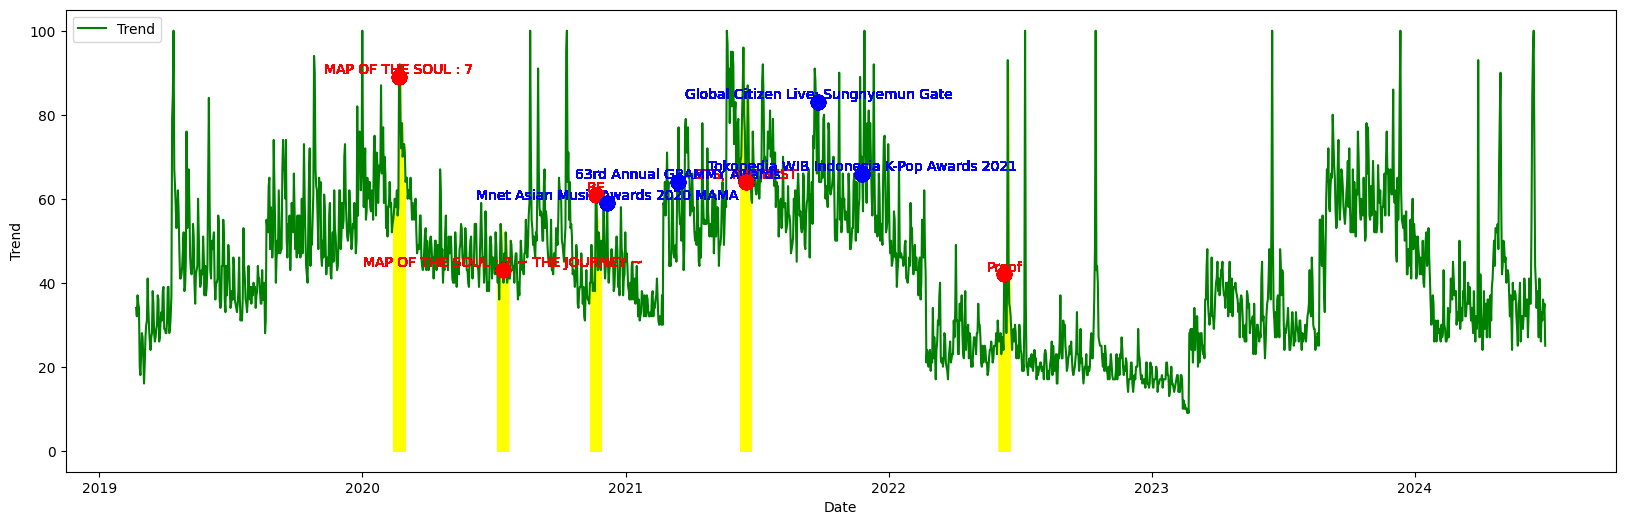

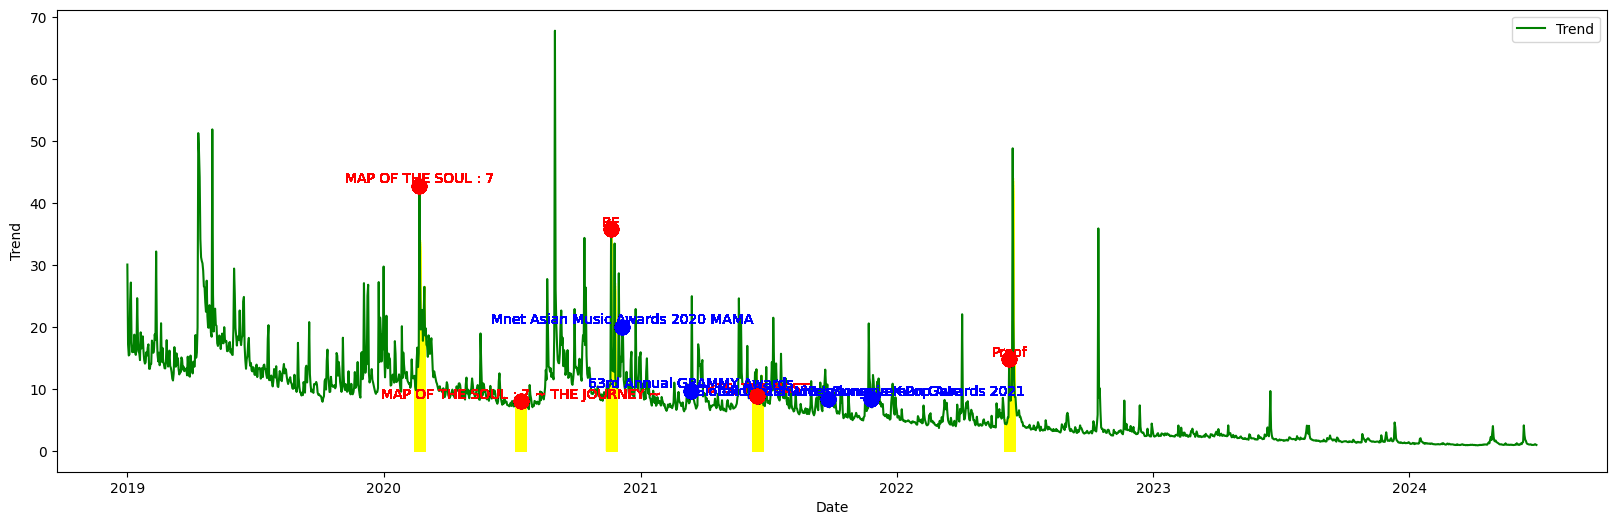

Stray Kids


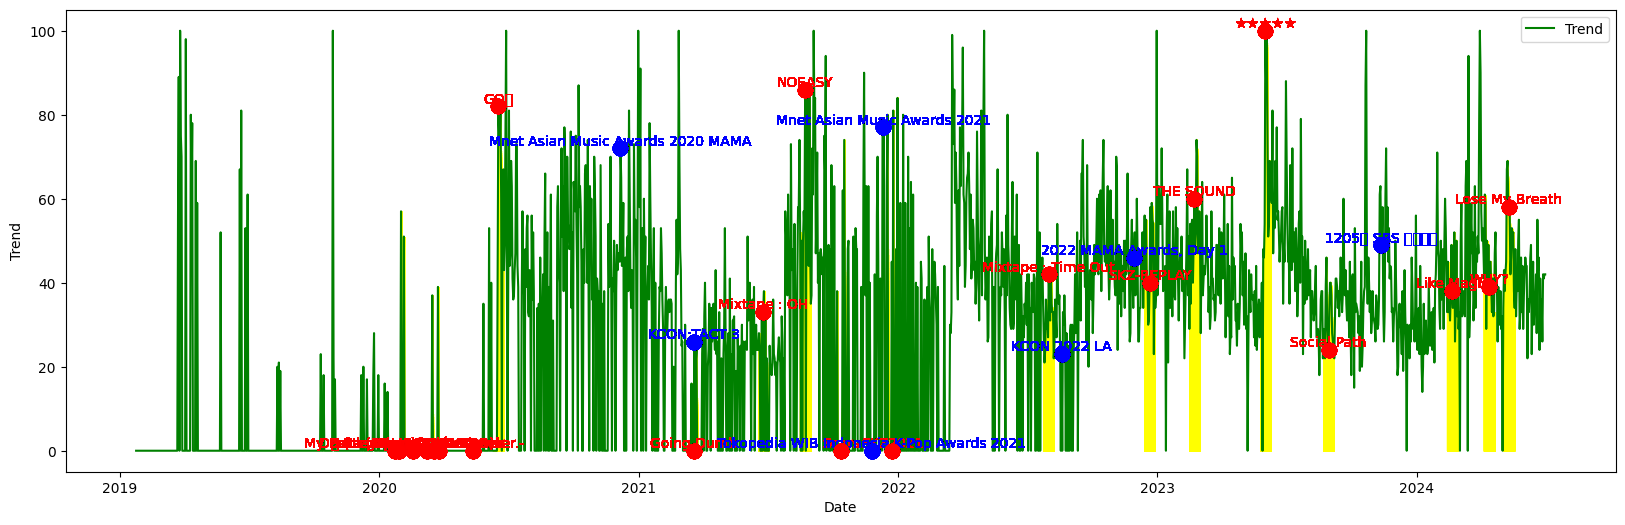

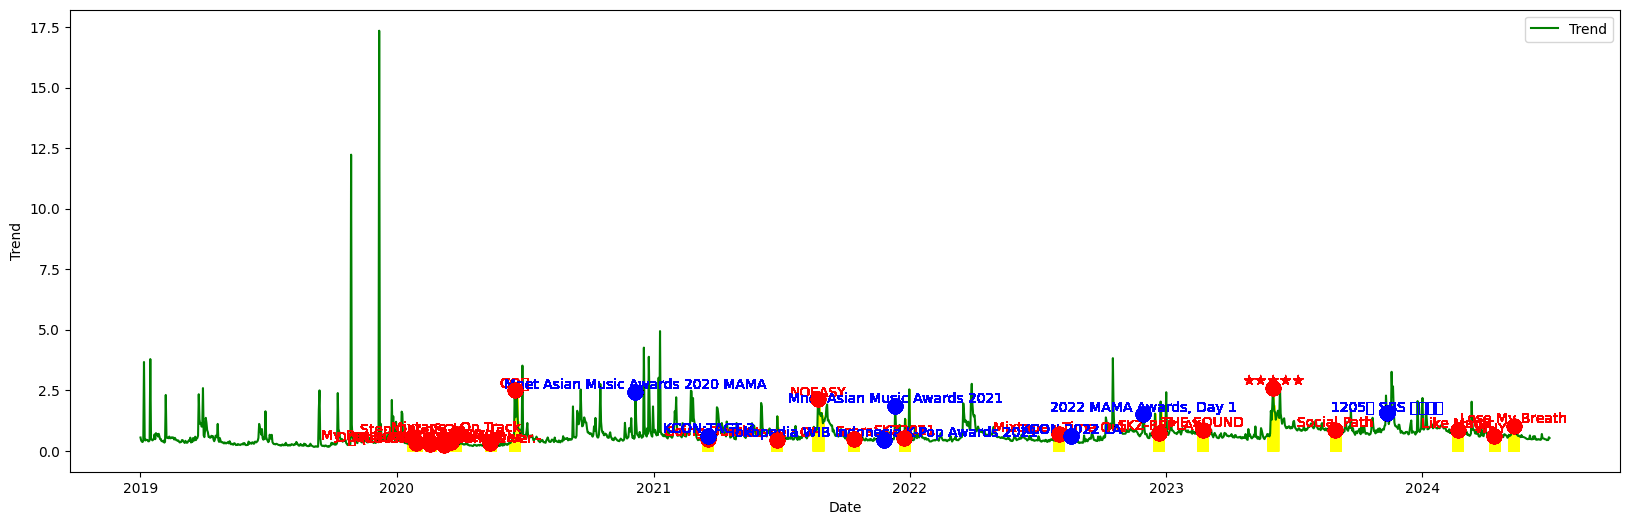

NCT DREAM


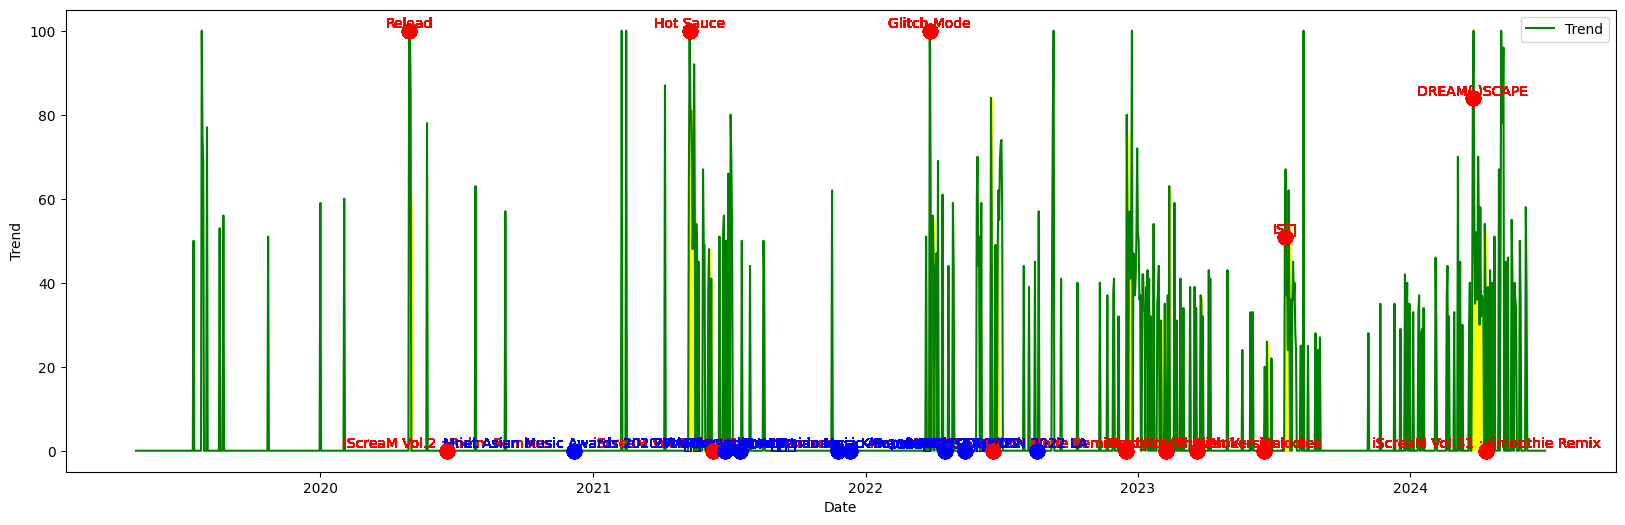

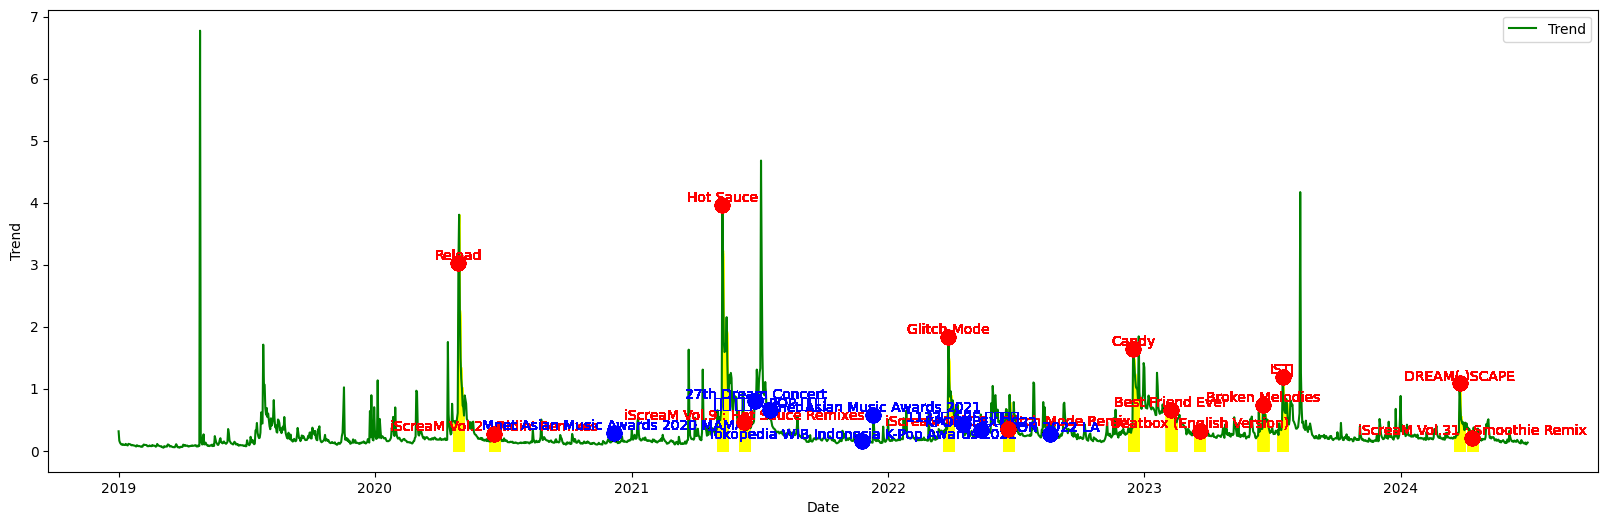

TOMORROW X TOGETHER


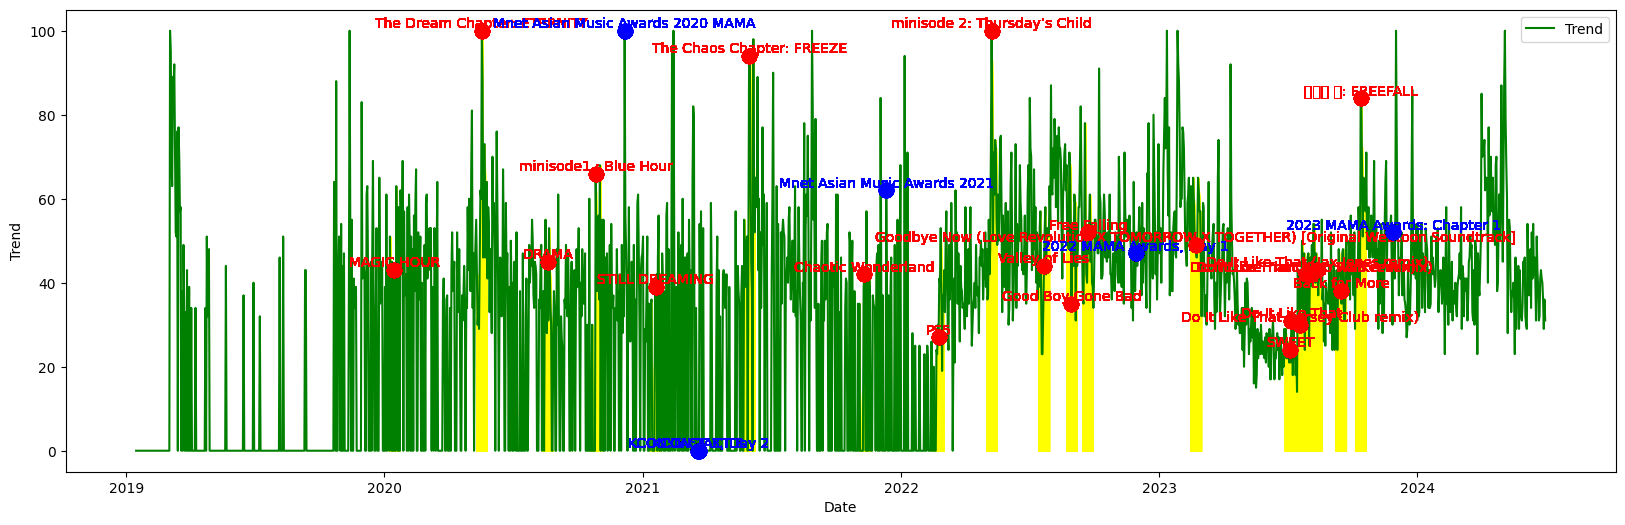

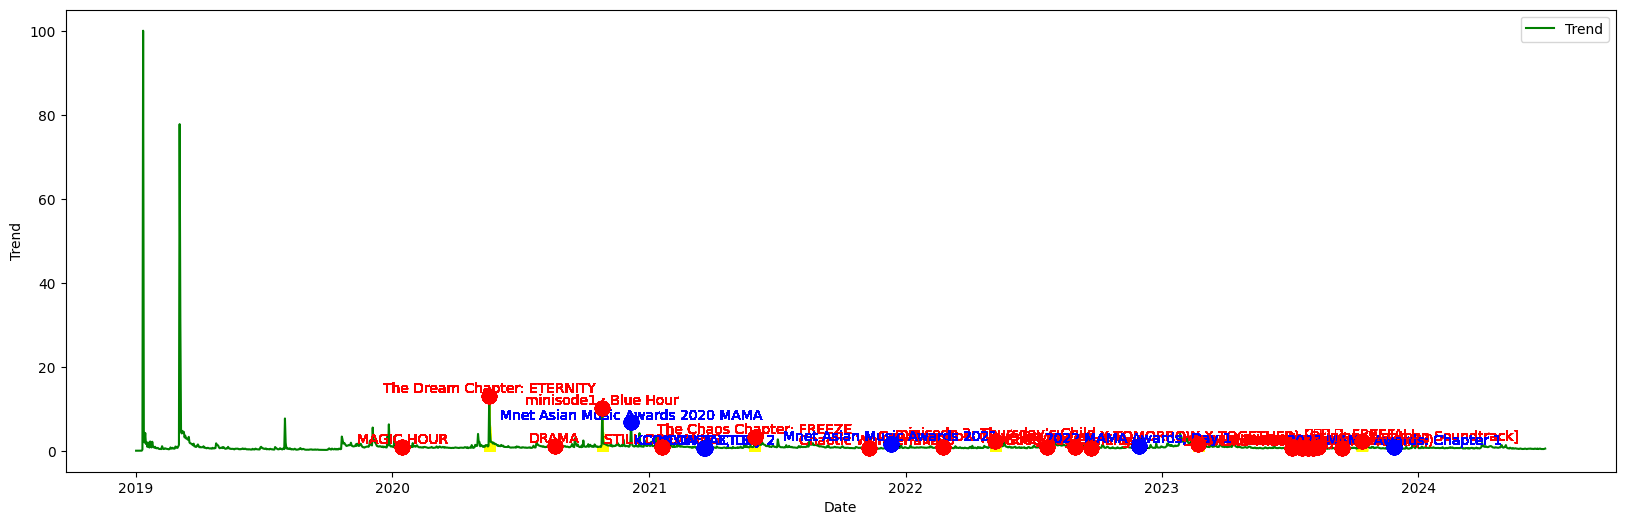

In [10]:
for artist_name in boy_group:

    print(artist_name)
    show_daily_trends(google_trend_dic[artist_name], artist_info_dic[artist_name])
    show_daily_trends(naver_trend_dic[artist_name], artist_info_dic[artist_name])

IVE


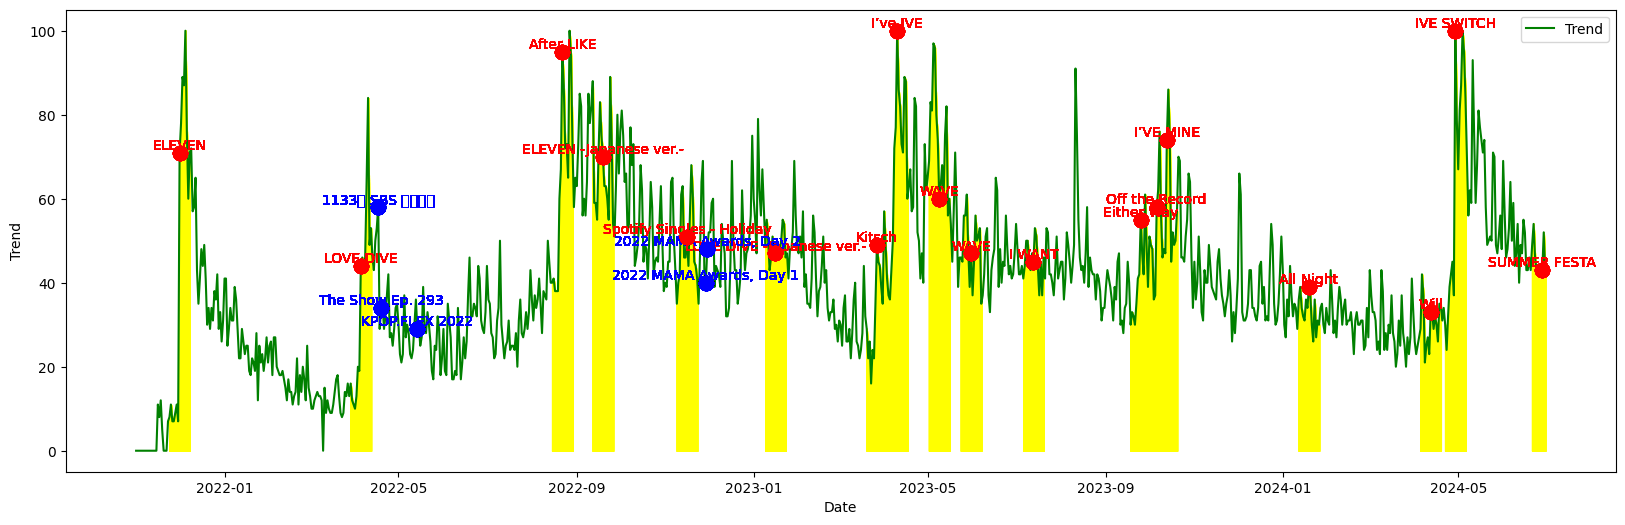

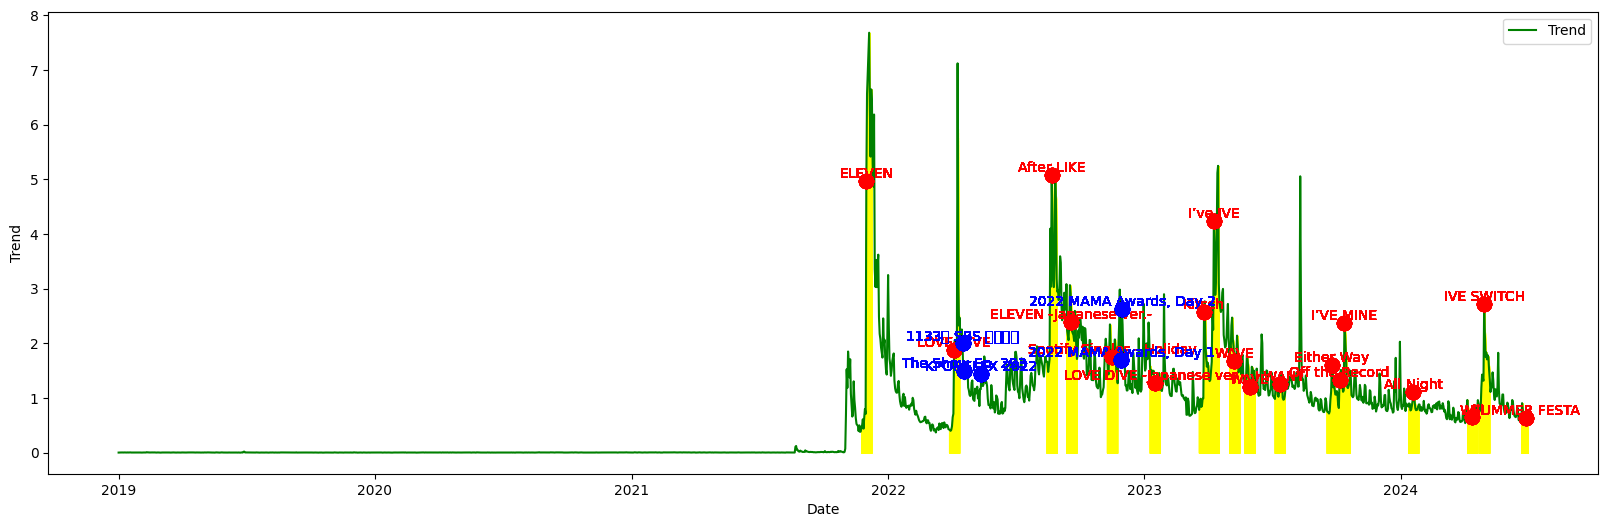

aespa


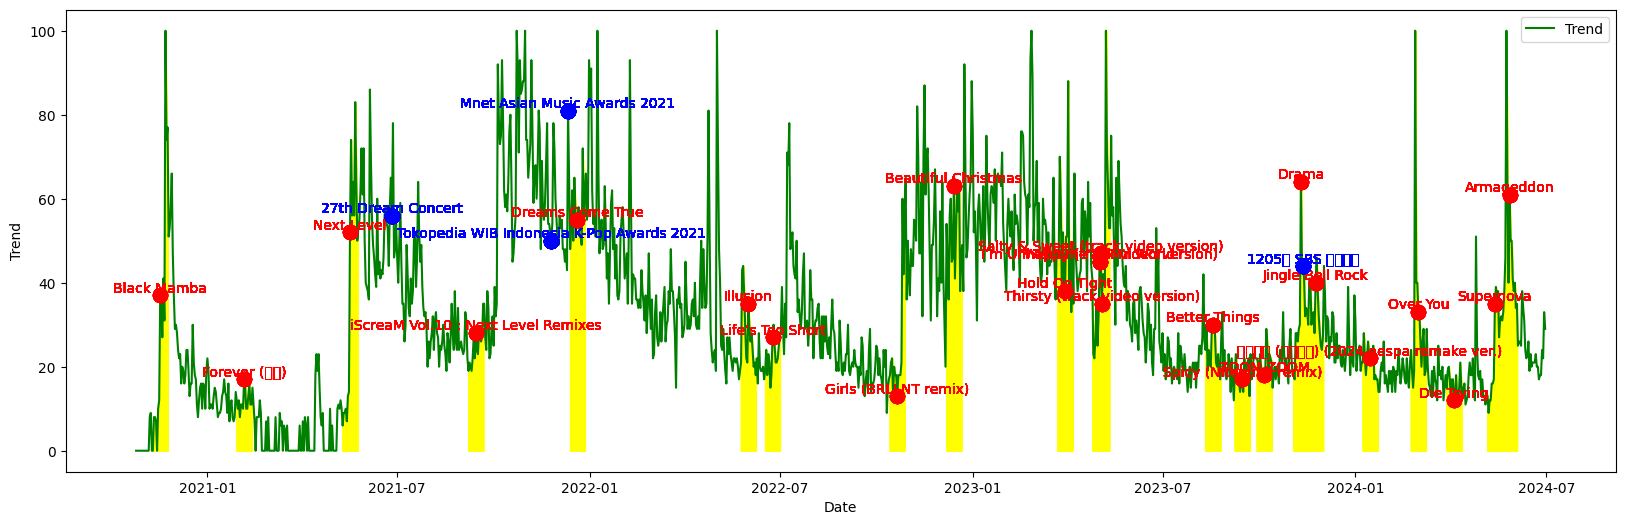

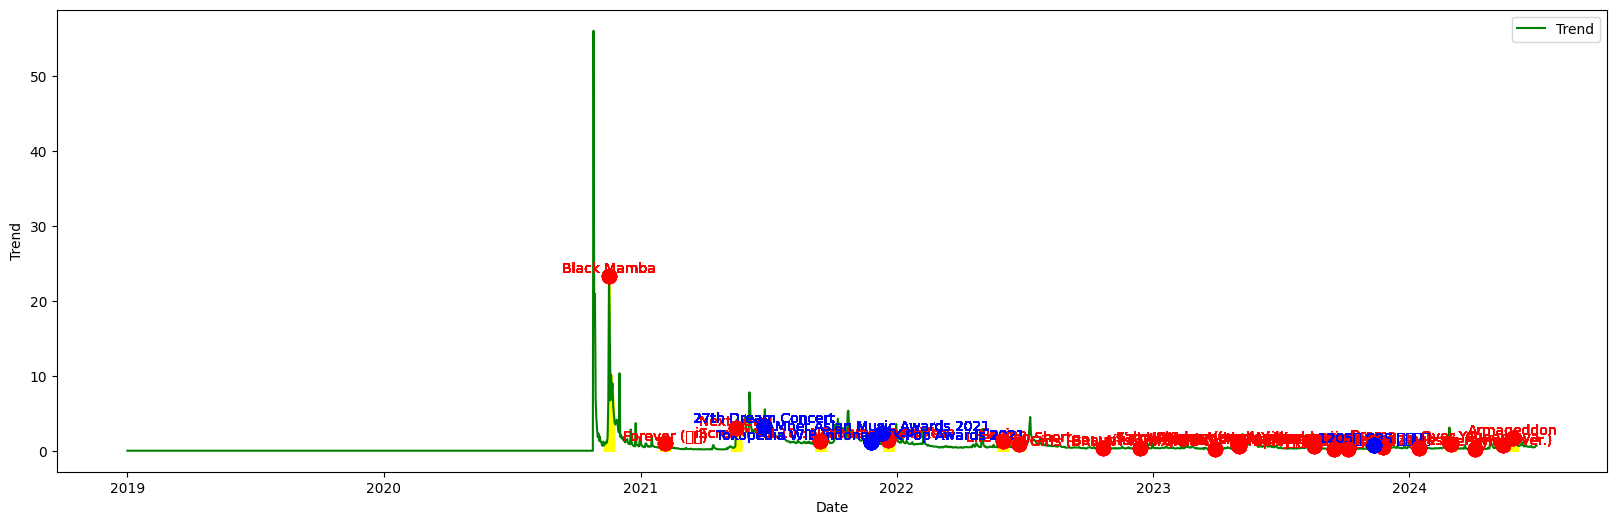

NewJeans


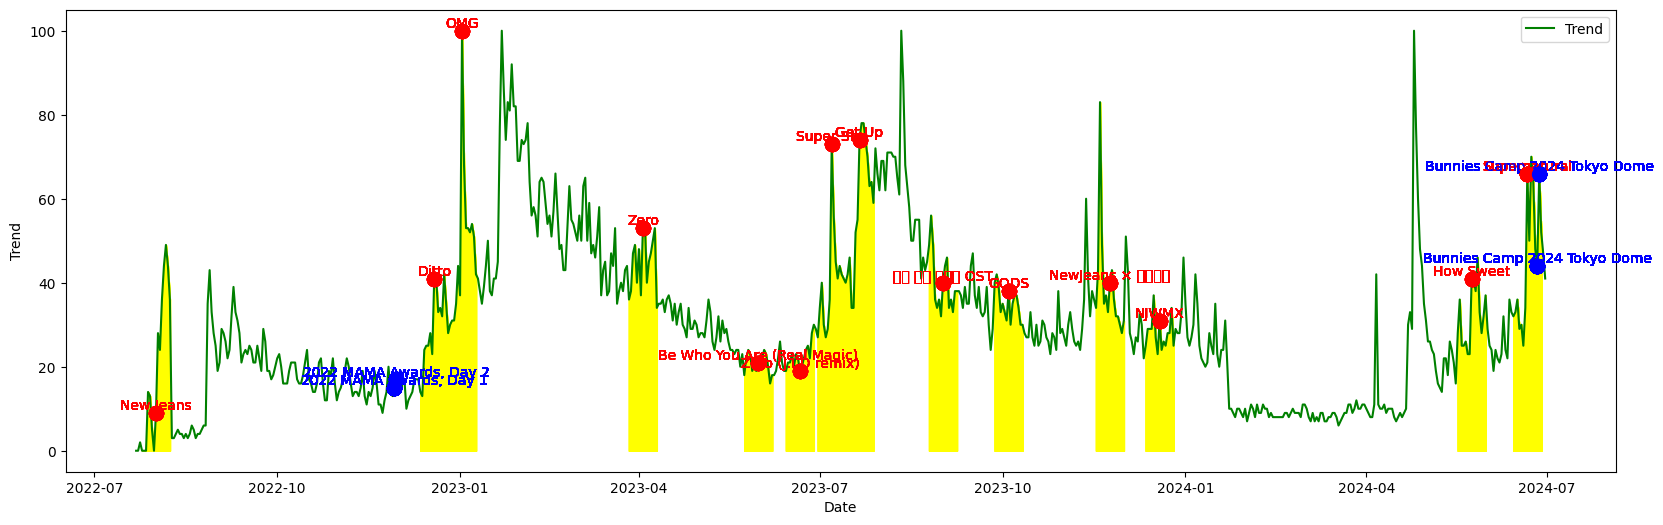

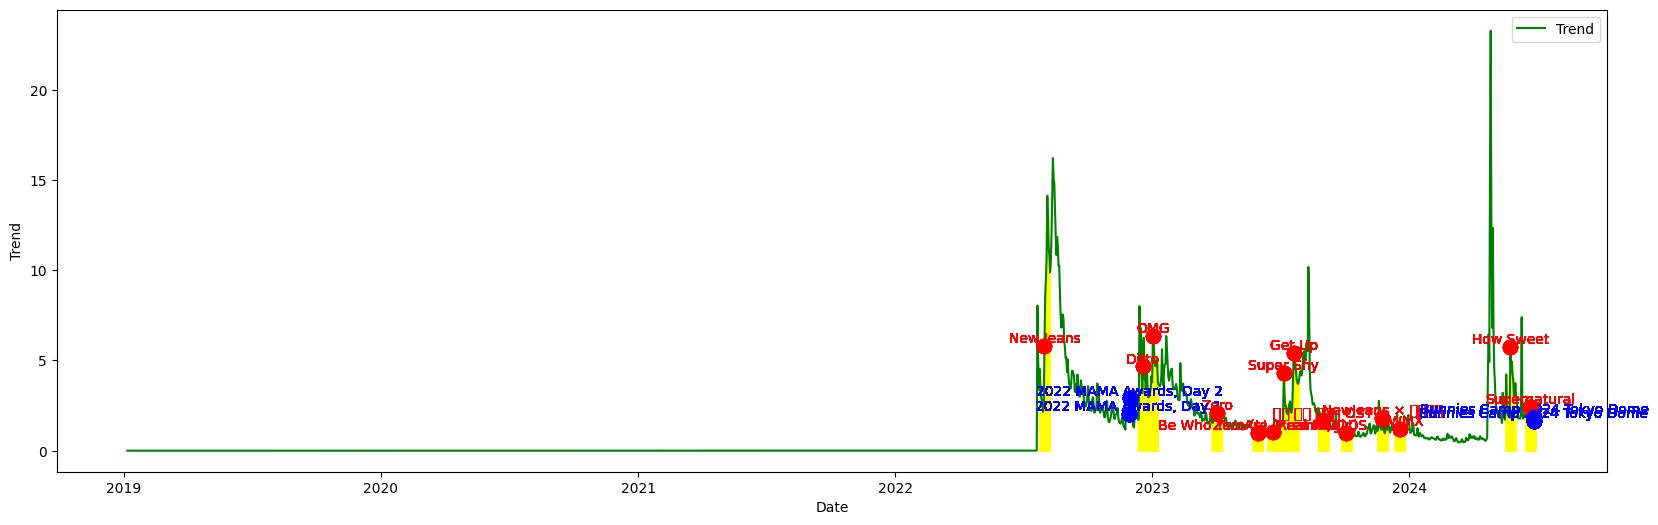

TWICE


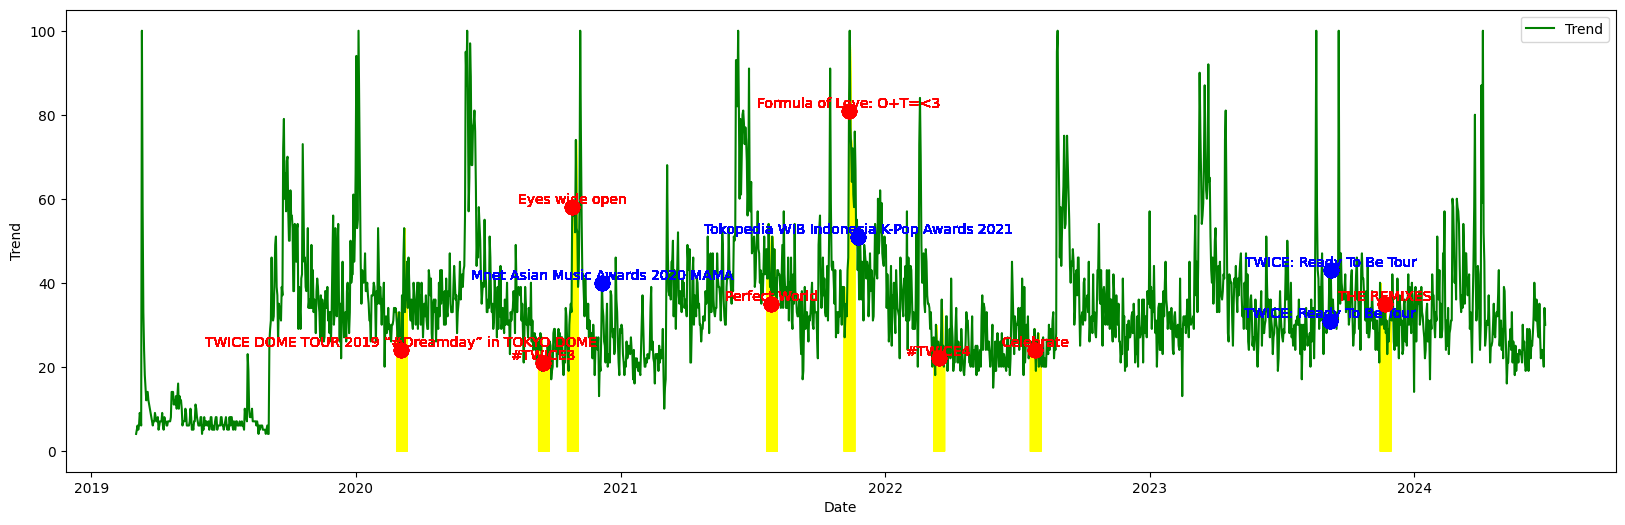

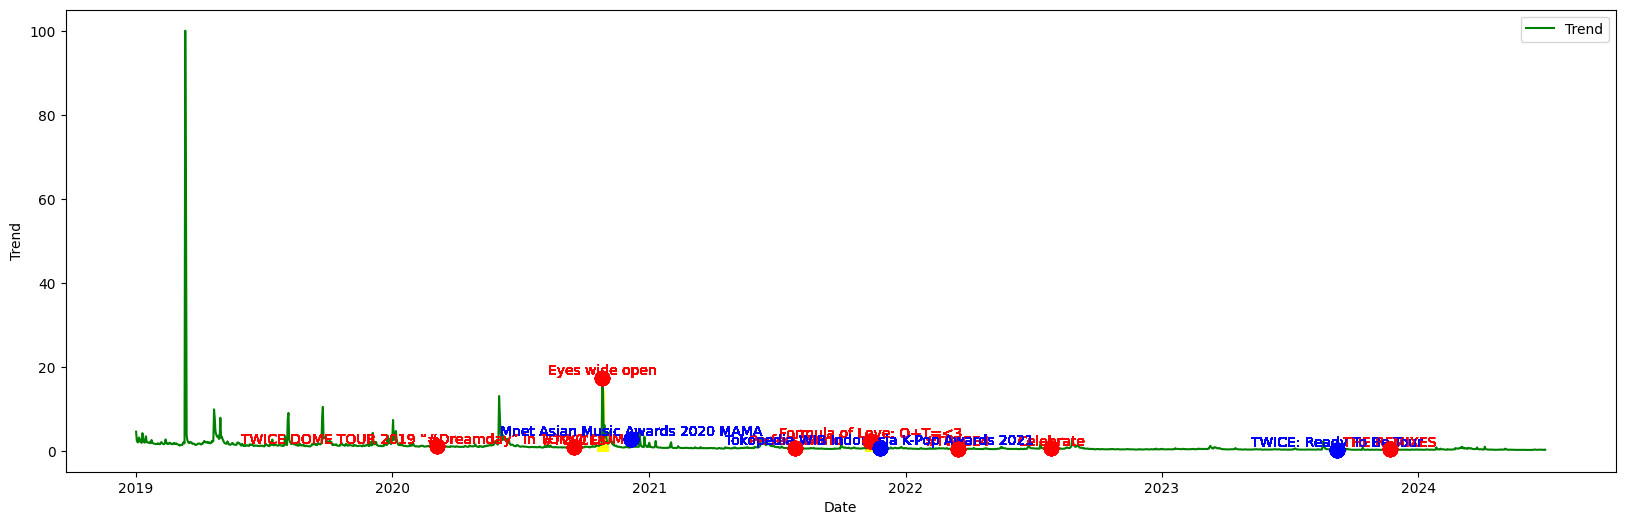

BLACKPINK


In [28]:
for artist_name in girl_group:

    print(artist_name)
    show_daily_trends(google_trend_dic[artist_name], artist_info_dic[artist_name])
    show_daily_trends(naver_trend_dic[artist_name], artist_info_dic[artist_name])

# 전처리
* 구글 트렌드에 한하여 우선적으로 진행
* 네이버 트렌드의 경우, 최대, 최소값 너무 극단적으로 나옴
    * 검색 방법 고민 필요
    * noise 이상치 처리
    * scaling 수행

In [24]:
# google trend 지수 0 또는 null 값 개수
# 그룹명 특성 상 nct dream이 트렌드 검색량 조회가 잘 안됨
{artist : f'{len(trend_df[(trend_df["trend"] == 0) | (trend_df["trend"].isnull() == True)])} / {len(trend_df)}' for artist, trend_df in google_trend_dic.items()}

{'aespa': '65 / 1345',
 'BLACKPINK': '2 / 1875',
 'BTS': '0 / 1957',
 'IVE': '19 / 973',
 'NCT DREAM': '1655 / 1890',
 'NewJeans': '6 / 710',
 'SEVENTEEN': '1 / 1836',
 'Stray Kids': '743 / 1985',
 'TOMORROW X TOGETHER': '595 / 1994',
 'TWICE': '0 / 1946'}

In [26]:
# naver trend 지수 0 또는 null 값 개수
# 0 또는 null값인 케이스가 많이 없으나, 시각화 결과 토대로 보았을때와 같이 최대 및 최소값 차이가 극단적으로 크게 나타남
{artist : f'{len(trend_df[(trend_df["trend"] == 0) | (trend_df["trend"].isnull() == True)])} / {len(trend_df)}' for artist, trend_df in naver_trend_dic.items()}

{'BTS': '0 / 2008',
 'NCT DREAM': '0 / 2008',
 'SEVENTEEN': '0 / 2008',
 'Stray Kids': '0 / 2008',
 'TOMORROW X TOGETHER': '0 / 2008',
 'aespa': '217 / 2008',
 'BLACKPINK': '0 / 2008',
 'IVE': '0 / 2008',
 'NewJeans': '1229 / 2008',
 'TWICE': '0 / 2008'}

# 시계열 분해

SEVENTEEN


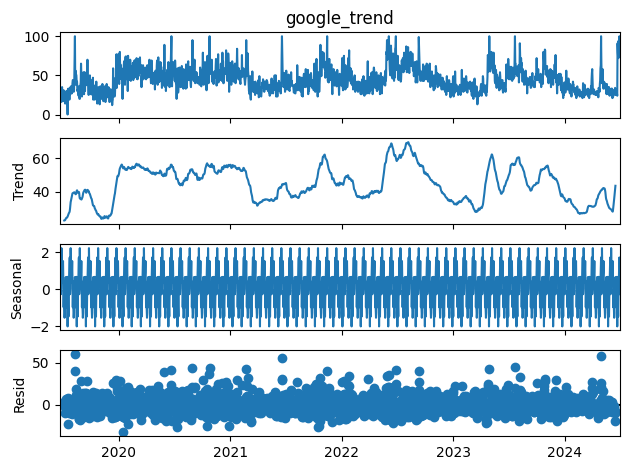

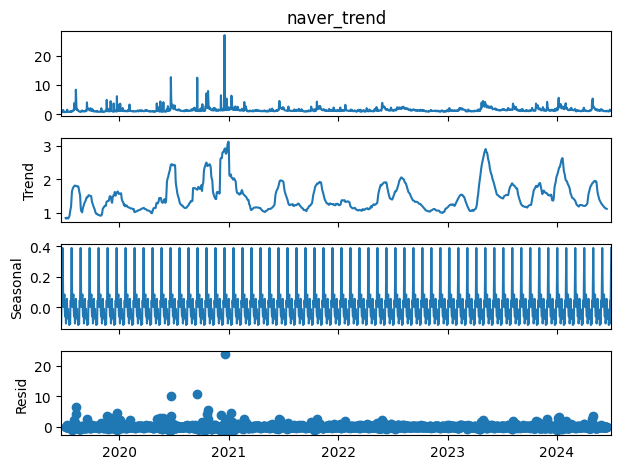

BTS


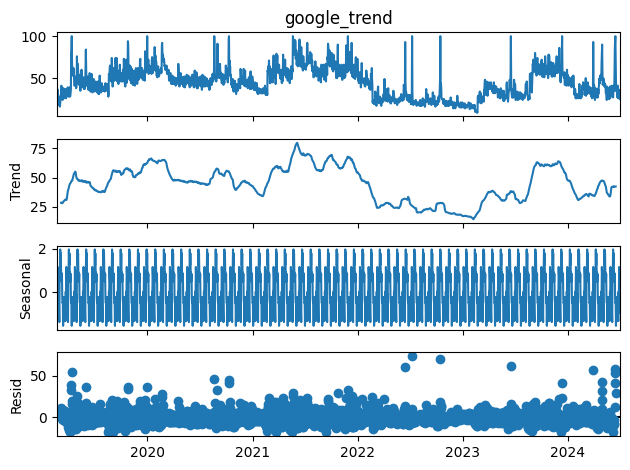

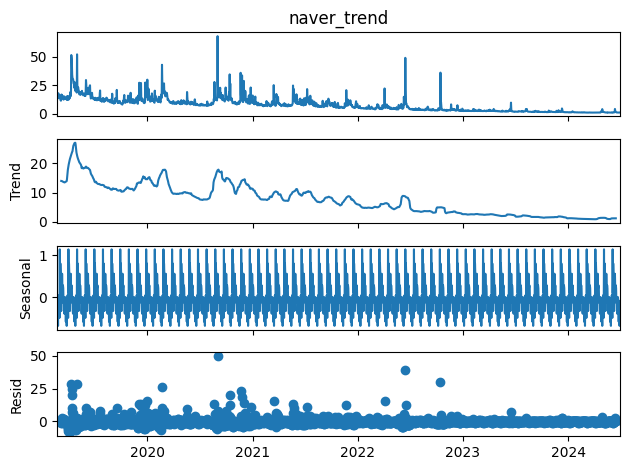

Stray Kids


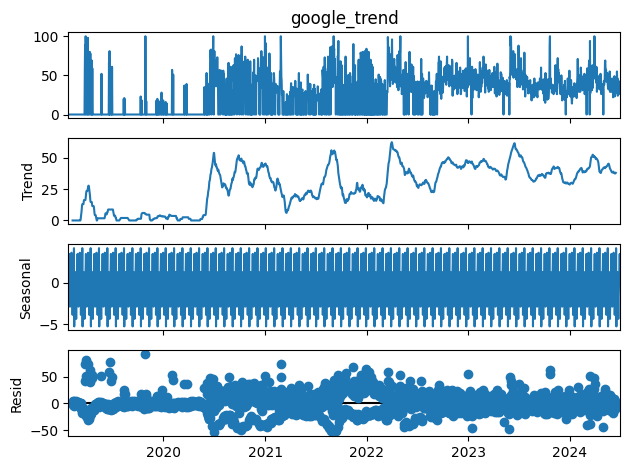

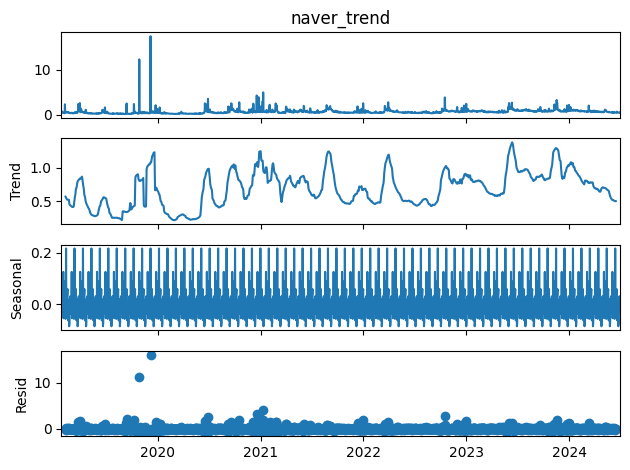

NCT DREAM


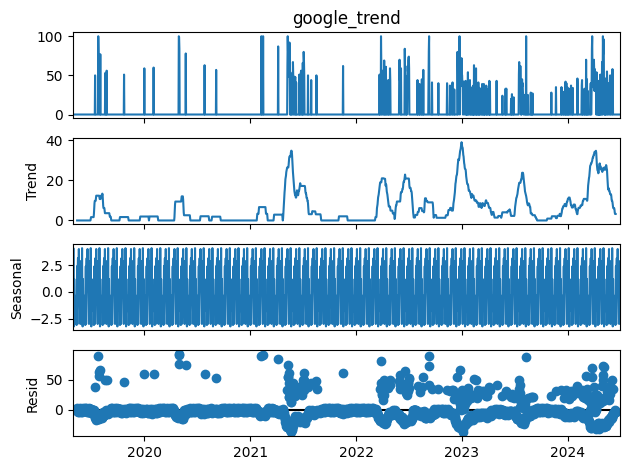

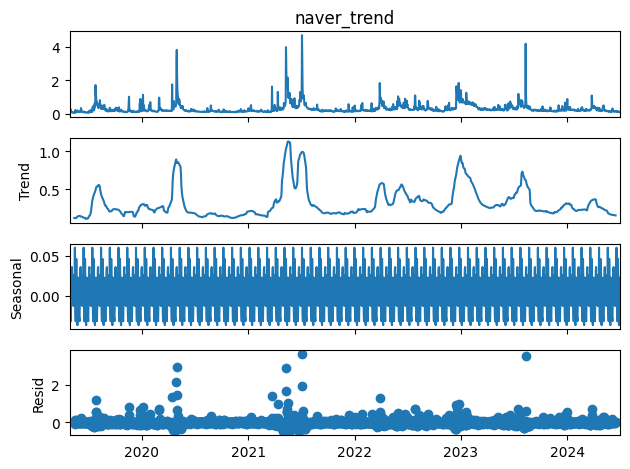

TOMORROW X TOGETHER


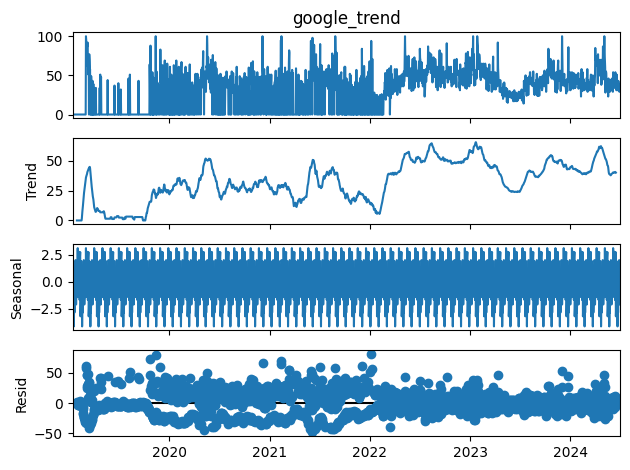

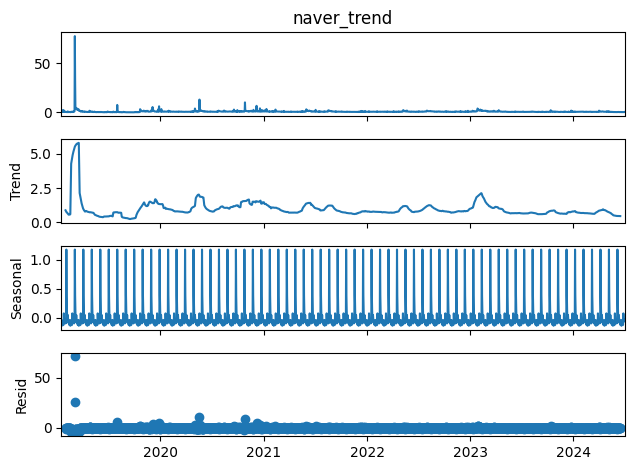

In [7]:
# 보이그룹
for artist_name in boy_group:

    print(artist_name)

    single_boy_df = pd.merge(google_trend_dic[artist_name], naver_trend_dic[artist_name], how='inner', on='date').rename(columns={'trend_x':'google_trend', 'trend_y':'naver_trend'}).set_index('date')

    result = seasonal_decompose(single_boy_df['google_trend'], model='addictive', period=30)
    result.plot()

    result = seasonal_decompose(single_boy_df['naver_trend'], model='addictive', period=30)
    result.plot()

    plt.show()